<a href="https://colab.research.google.com/github/Antares01/semester_project_ml_for_finance/blob/main/dataset_generation_semester_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
!pip install tf-quant-finance
import tf_quant_finance as tff 

option_price = tff.black_scholes.option_price


In [43]:
import numpy as np
import torch
from torch import nn
from scipy.stats import lognorm
from matplotlib import pyplot as plt
from scipy.ndimage.filters import uniform_filter1d

In [44]:
# option price generation parameters
TOT_OPTIONS = 1000
EXPIRY = 1.0
RATE = 0.0
SPOT = 30
STRIKE_MIN = 5
STRIKE_MAX = 150
VOLATILITY = 0.3

# NN parameters
MC_STEPS = 2**14
EPOCHS = 500
batch_size = 16

#distribution parameters
PROPOSAL_SIGMA = 0.3
PROPOSAL_MU = np.log(SPOT) - 0.5 * PROPOSAL_SIGMA**2 

INTERVAL_LENGTH = 300

In [45]:
"""
# Calculate discount factors (e^-rT)
rate = 0.05
expiries = np.array([0.5, 1.0, 2.0, 1.3])
discount_factors = np.exp(-rate * expiries)
# Current value of assets.
spots = np.array([0.9, 1.0, 1.1, 0.9])
# Forward value of assets at expiry.
forwards = spots / discount_factors
# Strike prices given by:
strikes = np.array([1.0, 2.0, 1.0, 0.5])
# Indicate whether options are call (True) or put (False)
is_call_options = np.array([True, True, False, False])
# The volatilites at which the options are to be priced.
volatilities = np.array([0.7, 1.1, 2.0, 0.5])
# Calculate the prices given the volatilities and term structure.
prices = option_price(
      volatilities=volatilities,
      strikes=strikes,
      expiries=expiries,
      forwards=forwards,
      discount_factors=discount_factors,
      is_call_options=is_call_options)
prices
"""


'\n# Calculate discount factors (e^-rT)\nrate = 0.05\nexpiries = np.array([0.5, 1.0, 2.0, 1.3])\ndiscount_factors = np.exp(-rate * expiries)\n# Current value of assets.\nspots = np.array([0.9, 1.0, 1.1, 0.9])\n# Forward value of assets at expiry.\nforwards = spots / discount_factors\n# Strike prices given by:\nstrikes = np.array([1.0, 2.0, 1.0, 0.5])\n# Indicate whether options are call (True) or put (False)\nis_call_options = np.array([True, True, False, False])\n# The volatilites at which the options are to be priced.\nvolatilities = np.array([0.7, 1.1, 2.0, 0.5])\n# Calculate the prices given the volatilities and term structure.\nprices = option_price(\n      volatilities=volatilities,\n      strikes=strikes,\n      expiries=expiries,\n      forwards=forwards,\n      discount_factors=discount_factors,\n      is_call_options=is_call_options)\nprices\n'

In [46]:
rates = np.array([RATE]*TOT_OPTIONS)
discount_factors = np.exp(- (rates)*EXPIRY)
spots = np.array([SPOT]*TOT_OPTIONS)
forwards = spots / discount_factors
strikes = np.linspace(STRIKE_MIN, STRIKE_MAX, TOT_OPTIONS)
is_call_options = np.random.choice(a=[False, True], size=(TOT_OPTIONS,))
volatilities = np.array([VOLATILITY]*TOT_OPTIONS)
expiries = np.array([EXPIRY]*TOT_OPTIONS)
prices = option_price(
      volatilities=volatilities,
      strikes=strikes,
      expiries=EXPIRY,
      forwards=forwards,
      discount_factors=discount_factors,
      is_call_options=is_call_options)

In [47]:
prices

<tf.Tensor: shape=(1000,), dtype=float64, numpy=
array([6.75690615e-10, 1.24273924e-09, 2.22865992e-09, 2.45645646e+01,
       2.44194194e+01, 2.42742743e+01, 2.41291291e+01, 2.39839840e+01,
       2.38388389e+01, 2.36936938e+01, 1.13375300e-07, 2.34034036e+01,
       2.56268827e-07, 2.31131135e+01, 2.29679685e+01, 2.28228236e+01,
       2.26776788e+01, 2.25325341e+01, 2.23873896e+01, 3.01833387e-06,
       2.20971012e+01, 2.19519575e+01, 7.45603456e-06, 2.16616716e+01,
       2.15165296e+01, 1.70845880e-05, 2.21854478e-05, 2.10811097e+01,
       3.66367581e-05, 2.07908374e+01, 2.06457046e+01, 2.05005746e+01,
       9.25661064e-05, 2.02103252e+01, 2.00652072e+01, 1.99200947e+01,
       2.13783468e-04, 1.96298899e+01, 3.15341824e-04, 1.93397197e+01,
       1.91946510e+01, 5.46272655e-04, 6.50604985e-04, 1.87595306e+01,
       1.86145257e+01, 1.07384307e-03, 1.25976739e-03, 1.81796509e+01,
       1.71591019e-03, 1.78898806e+01, 2.30677016e-03, 2.66212923e-03,
       1.74555155e+01, 1.731

In [48]:
from torch.utils.data import DataLoader
prices = np.array(prices)
prices_and_strikes = [ (prices[i], strikes[i], is_call_options[i]) for i in range(TOT_OPTIONS)]

target_dataloader = DataLoader(prices_and_strikes , batch_size=batch_size, shuffle = True)
#test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [49]:
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 128),
            nn.LeakyReLU(1e-1),
            nn.Dropout(0.4),
            
            nn.Linear(128, 512),
            nn.LeakyReLU(1e-1),
            nn.Dropout(0.4),   

            nn.Linear(512, 128),
            nn.LeakyReLU(1e-1),
            nn.Dropout(0.4),
            nn.Linear(128, 1)
        )
        
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = torch.sigmoid(x)
        return x


class LognormalNet(nn.Module):
  def __init__(self):
    super(LognormalNet, self).__init__()
    self.sigma = nn.Parameter(torch.Tensor([PROPOSAL_SIGMA]))
    self.mu = nn.Parameter(torch.Tensor([PROPOSAL_MU]))

  def forward(self, x):
    return 1/(x * self.sigma * np.sqrt(2* np.pi)) * torch.exp(-(torch.log(x) - self.mu)**2 / (2* self.sigma)**2 )

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = BaselineNet().to(device)
print(model)

Using cuda device
BaselineNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): LeakyReLU(negative_slope=0.1)
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [51]:
class OptionLoss(nn.Module):
    def __init__(self, beta):
        super(OptionLoss,self).__init__()
        self.beta = beta
    
    # outputs the MC_STEPS predictions, labels the TOT_OPTIONS labels
    def forward(self, outputs, labels, strikes, is_call_option, coordinates):
        loss = 0
        mc_integral = 0
        payoff = lambda  j :  torch.max(torch.zeros(MC_STEPS), coordinates - strikes[j] ) if is_call_options[j] else torch.max(torch.zeros(MC_STEPS), strikes[j] - coordinates)
        #densities_ratio = torch.div(outputs , torch.Tensor([lognorm.pdf(coordinates, PROPOSAL_SIGMA, 0, np.exp(PROPOSAL_MU)) ]))
        #print(outputs)
        #print(torch.Tensor([lognorm.pdf(coordinates, 1, 0, SPOT) + 1e-4]))
        #print(densities_ratio)
        for j in range(len(labels)):
          numerator  = payoff(j)
          mc_price = numerator * outputs
          #print(coordinates)
          #print(strikes[j])
          #print(numerator)
          #print(mc_price)
          loss += (labels[j] - INTERVAL_LENGTH * mc_price.sum() / MC_STEPS)**2
        
        
        for i in range(MC_STEPS - 1):
          mc_integral += (coordinates[i+1] - coordinates[i])*(outputs[i+1] - outputs[i])
        
        #print("custom loss is " + str(loss))
        #print("mc integral " + str(mc_integral))
        #print("integral loss is " + str(self.beta * (1 - 0.5*mc_integral)**2))
        return loss  + self.beta * (1 - 0.5*mc_integral)**2
            

In [52]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = OptionLoss(1e6)

In [53]:
loss_history = []
for _ in range(EPOCHS):
    for batch, (target_prices, strike_prices, is_call) in enumerate(target_dataloader):
        X = torch.zeros(MC_STEPS, 1).to(device)
        X.uniform_(0, INTERVAL_LENGTH)
        #print(X)
        pred = model(X)
        loss = loss_fn(pred.cpu().squeeze(), target_prices, strike_prices, is_call, X.cpu().squeeze())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e1)
        optimizer.step()
    loss_history.append(float(loss))


KeyboardInterrupt: ignored

In [ ]:
# EXPERIMENT 
i = 39
X = torch.zeros(MC_STEPS)
X.log_normal_(PROPOSAL_MU, PROPOSAL_SIGMA)
X = np.array(X)
prices[i], strikes[i], is_call_options[i]
payoff =   np.maximum(np.zeros(MC_STEPS), X - strikes[i] ) if is_call_options[i] else np.maximum(np.zeros(MC_STEPS), strikes[i] - X)
print( ( prices[i] - (payoff.sum() / MC_STEPS))**2 )


In [ ]:
x = np.linspace(1, 300, num = MC_STEPS)
y = lognorm.pdf(x, PROPOSAL_SIGMA, 0, np.exp(PROPOSAL_MU))
plt.plot(x, y)

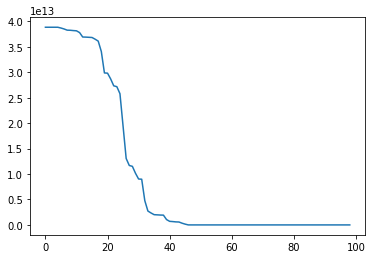

In [54]:
running_loss_average = uniform_filter1d(loss_history, size=50)
plt.plot(range(len(running_loss_average)), running_loss_average)

In [55]:
loss_history

[318097896638207.7,
 68866352389458.71,
 8473493697784.557,
 68043281458871.62,
 56395463099919.34,
 2097769731938.8513,
 210578960536713.72,
 102115679188251.92,
 18930913473734.066,
 16646194079253.188,
 1790612654750.2207,
 1900011609251.4214,
 928599508027.5234,
 43598487799379.164,
 17321243082930.242,
 2360416930711.8364,
 3071773303715.291,
 1125239736439.5137,
 11693320644591.217,
 9286477108725.271,
 7497134235944.262,
 110362859778.0146,
 4099081275.0925817,
 3074627075.670033,
 3805570154.1255817,
 4550884852.601984,
 6835875655.53394,
 2972705676.136484,
 4054558125.507847,
 3778326297.8742876,
 3415759602.520786,
 2937480896.944376,
 2627717004.047287,
 2606432133.300955,
 3531302614.0883904,
 2188325360.6653614,
 2553214791.1623077,
 5175524953.900019,
 2878799459.4987454,
 5551491499.918672,
 4347683991.751502,
 2952690628.585766,
 3352078215.644764,
 3725358535.442657,
 5238165433.555931,
 4840198568.038635,
 3235793900.071313,
 3285647481.663577,
 4017662404.592965,
 2

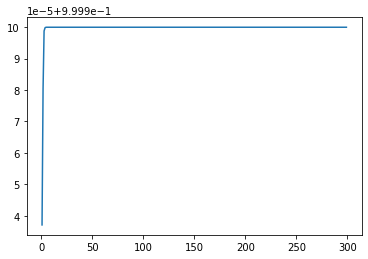

In [57]:
x = torch.Tensor(np.arange(1, 300)).to(device).unsqueeze(-1)
p = model(x)
plt.plot(x.cpu().detach().numpy(), p.cpu().detach().numpy())

In [58]:
p

tensor([[0.9999],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1

In [ ]:
for para in model.parameters():
    print(para)

In [ ]:
np.any(np.array(np.isnan(x)))